<a href="https://colab.research.google.com/github/Mechanics-Mechatronics-and-Robotics/CV-2025/blob/main/Week_07/Hands_on_Triplet_margin_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

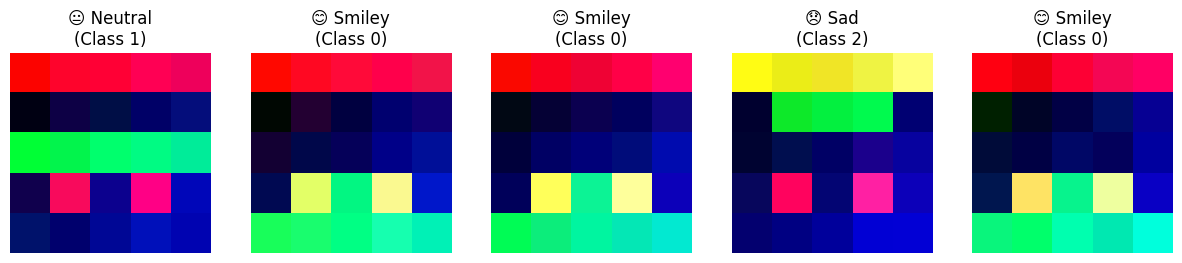

Epoch 1, Loss: 0.2010, LR: 0.001000
Epoch 2, Loss: 0.0000, LR: 0.001000
Epoch 3, Loss: 0.0000, LR: 0.001000
Epoch 4, Loss: 0.0000, LR: 0.001000
Epoch 5, Loss: 0.0000, LR: 0.000100
Epoch 6, Loss: 0.0000, LR: 0.000100
Epoch 7, Loss: 0.0000, LR: 0.000100
Epoch 8, Loss: 0.0000, LR: 0.000100
Epoch 9, Loss: 0.0000, LR: 0.000100
Epoch 10, Loss: 0.0000, LR: 0.000010
Epoch 11, Loss: 0.0000, LR: 0.000010
Epoch 12, Loss: 0.0000, LR: 0.000010
Epoch 13, Loss: 0.0000, LR: 0.000010
Epoch 14, Loss: 0.0000, LR: 0.000010
Epoch 15, Loss: 0.0000, LR: 0.000001


<ipython-input-4-9e444075afef>:188: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scat = ax.scatter([], [], cmap='tab10', alpha=0.7)  # No `c=` here!


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# =============================================
# Step 1: Synthetic Dataset (Improved)
# =============================================
class ToyFaceDataset(torch.utils.data.Dataset):
    def __init__(self, num_classes=3, samples_per_class=50):
        self.num_classes = num_classes
        self.samples_per_class = samples_per_class

        # 5x5 patterns: [R, G, B] channels
        self.base_patterns = [
            # 😊 Smiley (Class 0)
            [
                # Red channel (eyes)
                [[1,1,1,1,1],
                 [0,0,0,0,0],
                 [0,0,0,0,0],
                 [0,1,0,1,0],
                 [0,0,0,0,0]],
                # Green channel (mouth: bottom U-shape)
                [[0,0,0,0,0],
                 [0,0,0,0,0],
                 [0,0,0,0,0],
                 [0,1,1,1,0],
                 [1,1,1,1,1]],
                # Blue channel (background gradient)
                [[0.1*i + 0.1*j for j in range(5)] for i in range(5)]
            ],
            # 😐 Neutral (Class 1)
            [
                [[1,1,1,1,1],
                 [0,0,0,0,0],
                 [0,0,0,0,0],
                 [0,1,0,1,0],
                 [0,0,0,0,0]],
                [[0,0,0,0,0],
                 [0,0,0,0,0],
                 [1,1,1,1,1],
                 [0,0,0,0,0],
                 [0,0,0,0,0]],
                [[0.1*i + 0.1*j for j in range(5)] for i in range(5)]
            ],
            # 😞 Sad (Class 2)
            [
                [[1,1,1,1,1],
                 [0,0,0,0,0],
                 [0,0,0,0,0],
                 [0,1,0,1,0],
                 [0,0,0,0,0]],
                [[1,1,1,1,1],
                 [0,1,1,1,0],
                 [0,0,0,0,0],
                 [0,0,0,0,0],
                 [0,0,0,0,0]],
                [[0.1*i + 0.1*j for j in range(5)] for i in range(5)]
            ]
        ]

        self.data = []
        self.labels = []

        for class_id in range(num_classes):
            base = torch.tensor([
                self.base_patterns[class_id][0],  # R
                self.base_patterns[class_id][1],  # G
                self.base_patterns[class_id][2]   # B
            ], dtype=torch.float32)

            for _ in range(samples_per_class):
                # Add noise (no rotation)
                img = base + torch.randn(3, 5, 5) * 0.05
                self.data.append(img)
                self.labels.append(class_id)

        self.data = torch.stack(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def plot_smiley_faces(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    indices = torch.randperm(len(dataset))[:num_samples]

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img = img.permute(1, 2, 0).numpy()  # HWC -> WHC
        img = np.clip(img, 0, 1)

        # No rotation needed
        axes[i].imshow(img)
        expression = ["😊 Smiley", "😐 Neutral", "😞 Sad"][label]
        axes[i].set_title(f"{expression}\n(Class {label})")
        axes[i].axis('off')
    plt.show()

# Test dataset
dataset = SmileyFaceDataset()
plot_smiley_faces(dataset)

# =============================================
# Step 2: Model with Non-Linearity
# =============================================
class FaceEmbedder(nn.Module):
    def __init__(self, embedding_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*5*5, 64),  # Fix: 3 channels × 5×5 pixels = 75
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, embedding_dim)
        )

    def forward(self, x):
        return self.net(x)

# =============================================
# Step 3: Triplet Loss with Semi-Hard Mining
# =============================================
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super().__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = torch.norm(anchor - positive, p=2, dim=1)
        neg_dist = torch.norm(anchor - negative, p=2, dim=1)
        losses = torch.clamp(pos_dist - neg_dist + self.margin, min=0)
        return torch.mean(losses)

def get_triplets(labels):
    triplets = []
    for i in range(len(labels)):
        anchor_label = labels[i].item()
        pos_indices = np.where(labels.numpy() == anchor_label)[0]
        pos_idx = np.random.choice(pos_indices)
        neg_indices = np.where(labels.numpy() != anchor_label)[0]
        neg_idx = np.random.choice(neg_indices)
        triplets.append((i, pos_idx, neg_idx))
    return torch.LongTensor(triplets)

# =============================================
# Step 4: Training Loop (Fixed Animation)
# =============================================
def train_and_visualize():
    dataset = ToyFaceDataset(num_classes=3, samples_per_class=50)
    loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
    model = FaceEmbedder(embedding_dim=2)
    criterion = TripletLoss(margin=0.5)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    embedding_history = []

    for epoch in range(15):
        for batch in loader:
            imgs, labels = batch
            triplets = get_triplets(labels)
            anchor = model(imgs[triplets[:, 0]])
            positive = model(imgs[triplets[:, 1]])
            negative = model(imgs[triplets[:, 2]])
            loss = criterion(anchor, positive, negative)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        scheduler.step()
        embeddings = model(dataset.data).detach().numpy()
        embedding_history.append(embeddings)
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

    # Animation (Fixed)
    fig, ax = plt.subplots()
    scat = ax.scatter([], [], cmap='tab10', alpha=0.7)  # No `c=` here!
    plt.title("Embedding Evolution (Triplet Loss)")

    def update(frame):
        scat.set_offsets(embedding_history[frame])
        scat.set_array(dataset.labels)  # Set colors dynamically
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        return scat

    ani = FuncAnimation(fig, update, frames=len(embedding_history), interval=500)
    plt.close()
    return HTML(ani.to_jshtml())

# Run
ani = train_and_visualize()
display(ani)